<a href="https://colab.research.google.com/github/ShahedSabab/Credit-card-fraud-detection/blob/main/credit_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [574]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from matplotlib import rc
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report,accuracy_score,roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras import regularizers

%matplotlib inline

# Initialize Variables

In [441]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(COLORS_PALETTE))
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 24
np.random.seed(RANDOM_SEED)

# Read Data

In [442]:
df = pd.read_csv('creditcard.csv')

In [443]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


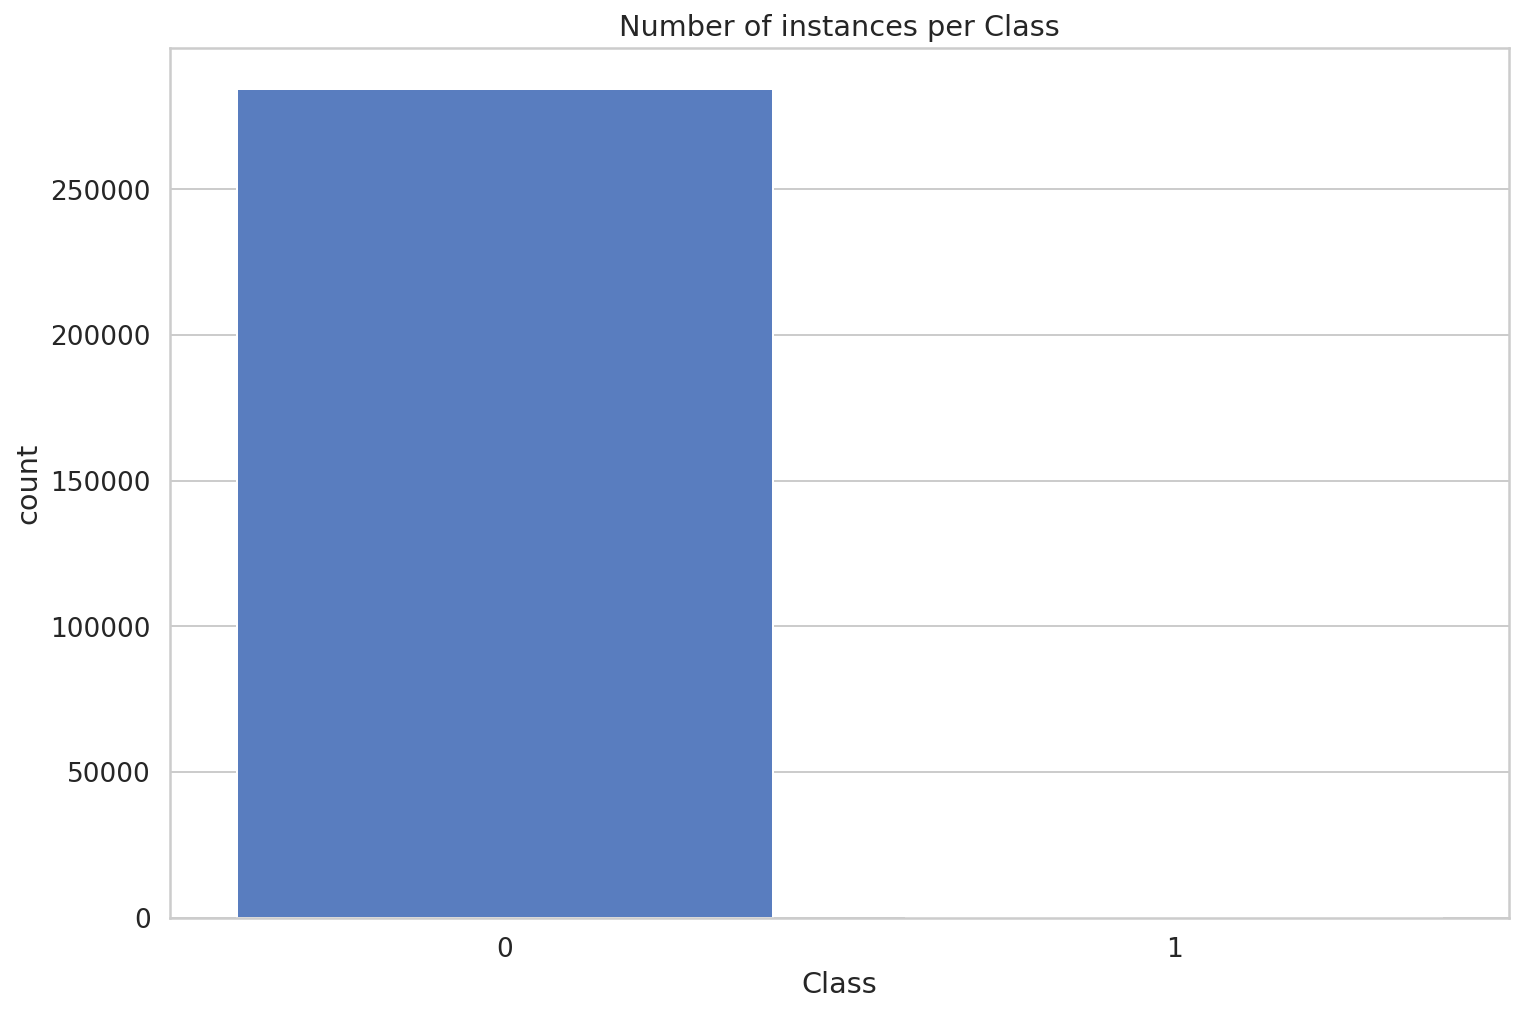

In [444]:
plt.title("Number of instances per Class")
sns.countplot(df.Class);
plt.show()

Only a few Fraud cases.

In [445]:
Non_fraud, Fraud = df['Class'].value_counts()

In [446]:
Non_fraud_perc = Non_fraud*100 / (Fraud+Non_fraud)
Fraud_perc = Fraud*100 / (Fraud+Non_fraud)

In [447]:
print("Fraud Percentage", Fraud_perc)
print("Non_fraud Percentage", Non_fraud_perc)


Fraud Percentage 0.1727485630620034
Non_fraud Percentage 99.827251436938


The minority Fraud class only has a few cases.

In [448]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


# EDA

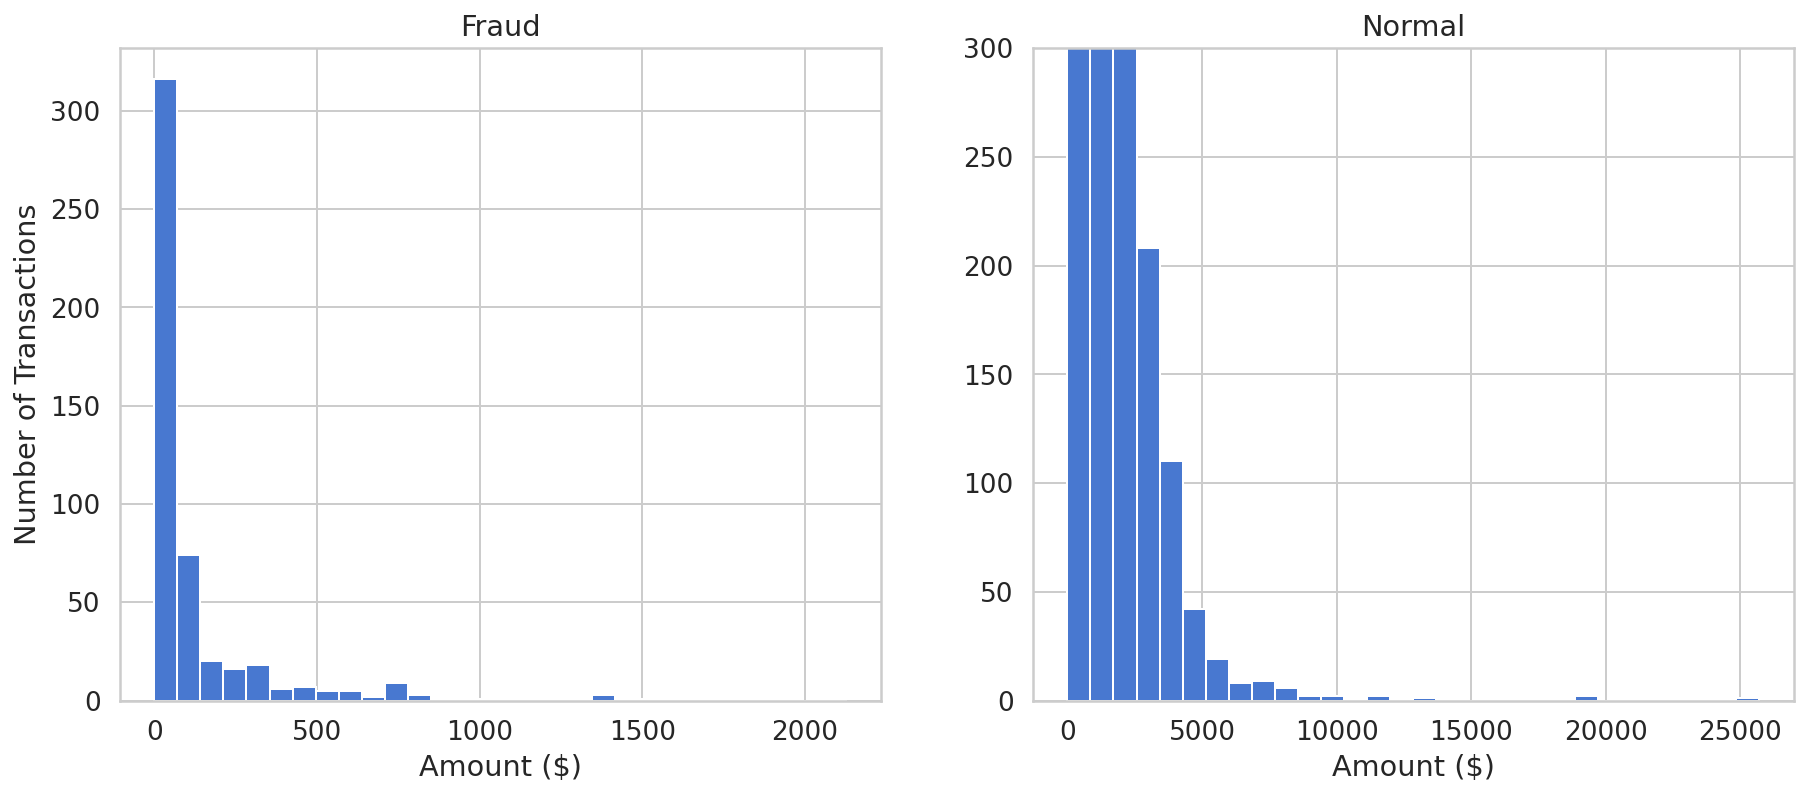

In [449]:

df_fraud = df[df['Class'] == 1]
df_ok = df[df['Class'] == 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
bins = 30

ax1.hist(df_fraud['Amount'], bins=bins)
ax2.hist(df_ok['Amount'], bins=bins)

ax1.set_title('Fraud')
ax2.set_title('Normal')

ax1.set_xlabel('Amount ($)')
ax2.set_xlabel('Amount ($)')
ax1.set_ylabel('Number of Transactions')

ax2.set_ylim(0, 300)
plt.show()

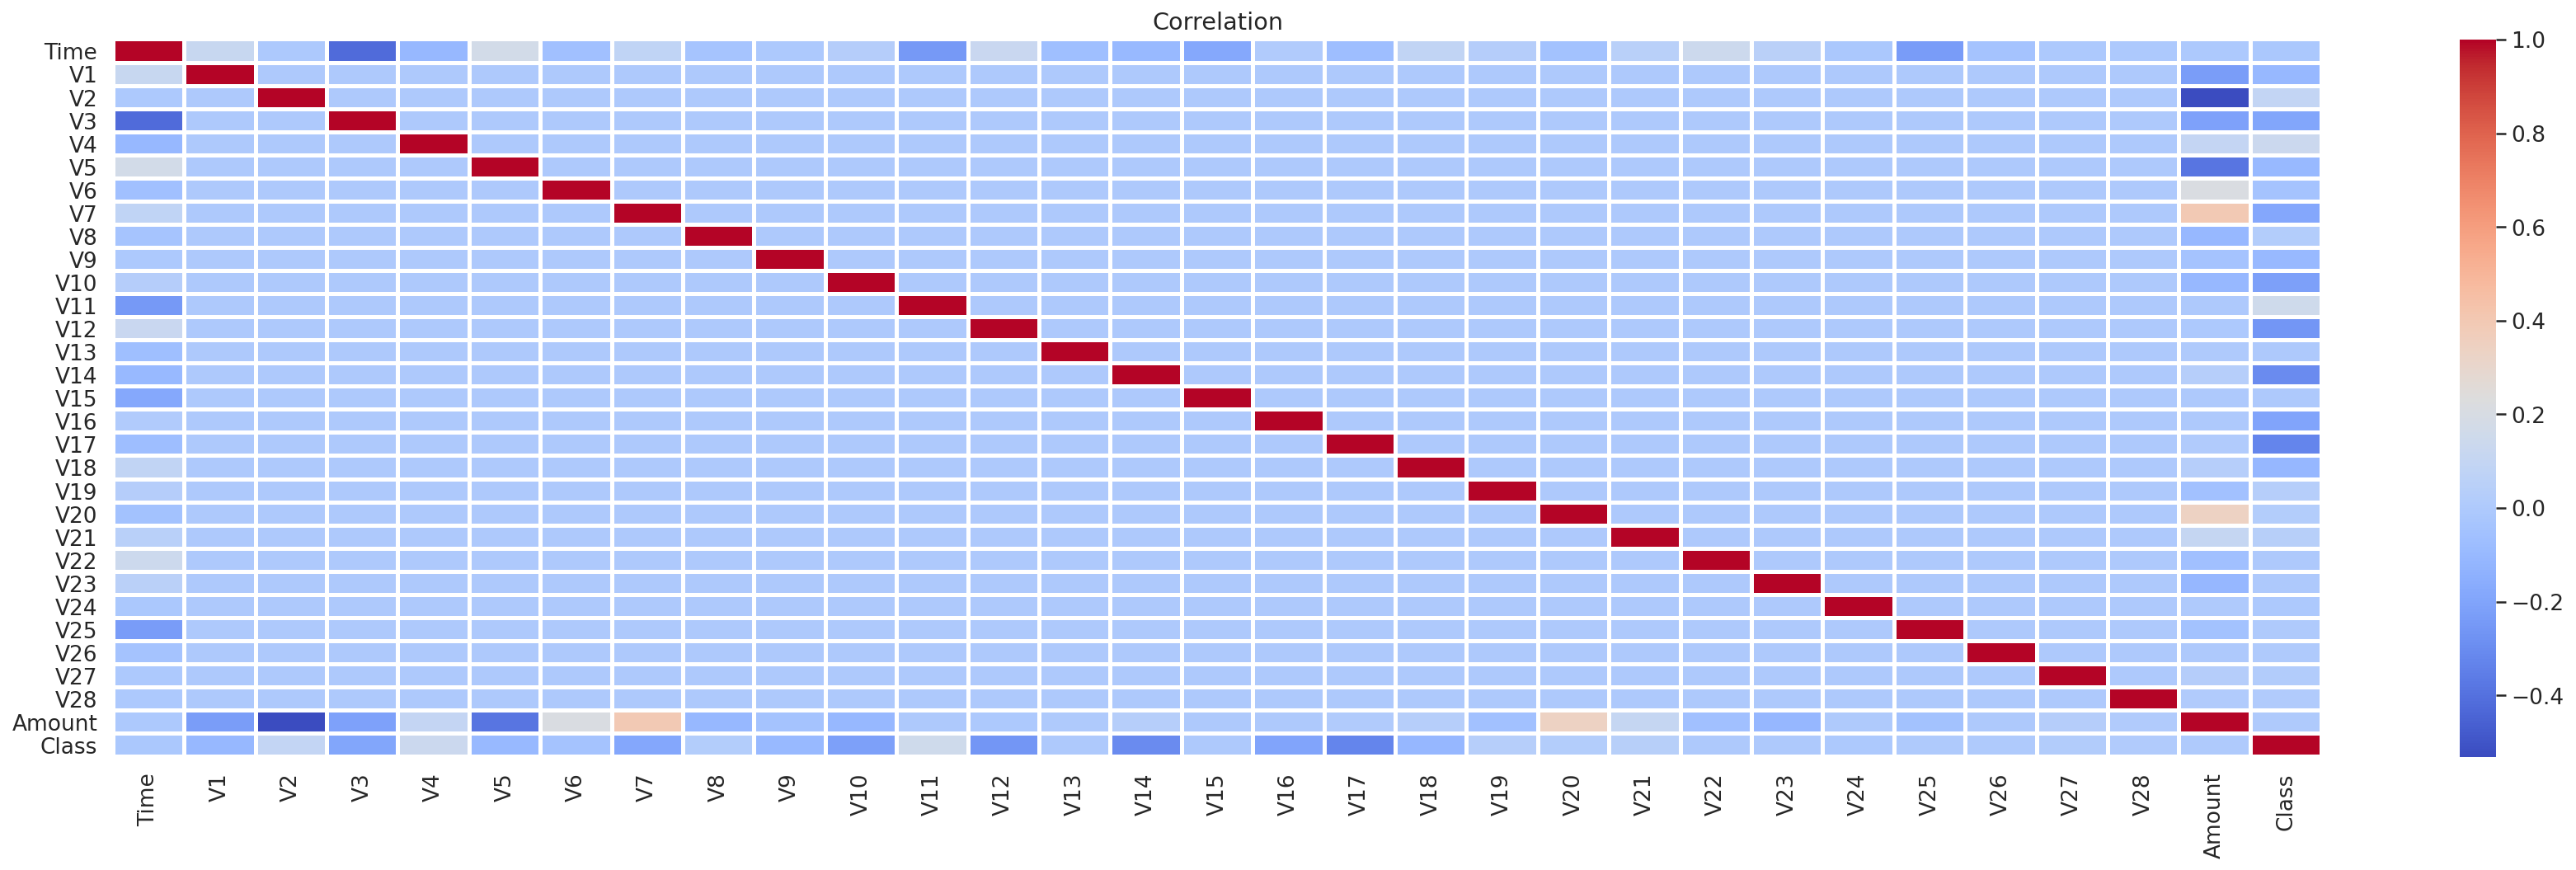

In [450]:
#check Pearson's correlation coeffcient
plt.figure(figsize=(30,8))
sns.heatmap(df.corr(),cmap='coolwarm', linewidth = 2,annot = False)
plt.title("Correlation")
plt.show()

# TSNE Visualization


In [451]:
non_fraud = df[df['Class']==0].sample(2000)
fraud = df[df['Class']==1]

df_subsample = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df_subsample.drop(['Class'], axis = 1).values
y = df_subsample['Class'].values

In [452]:
p = TSNE(n_components=2, random_state=RANDOM_SEED).fit_transform(X)

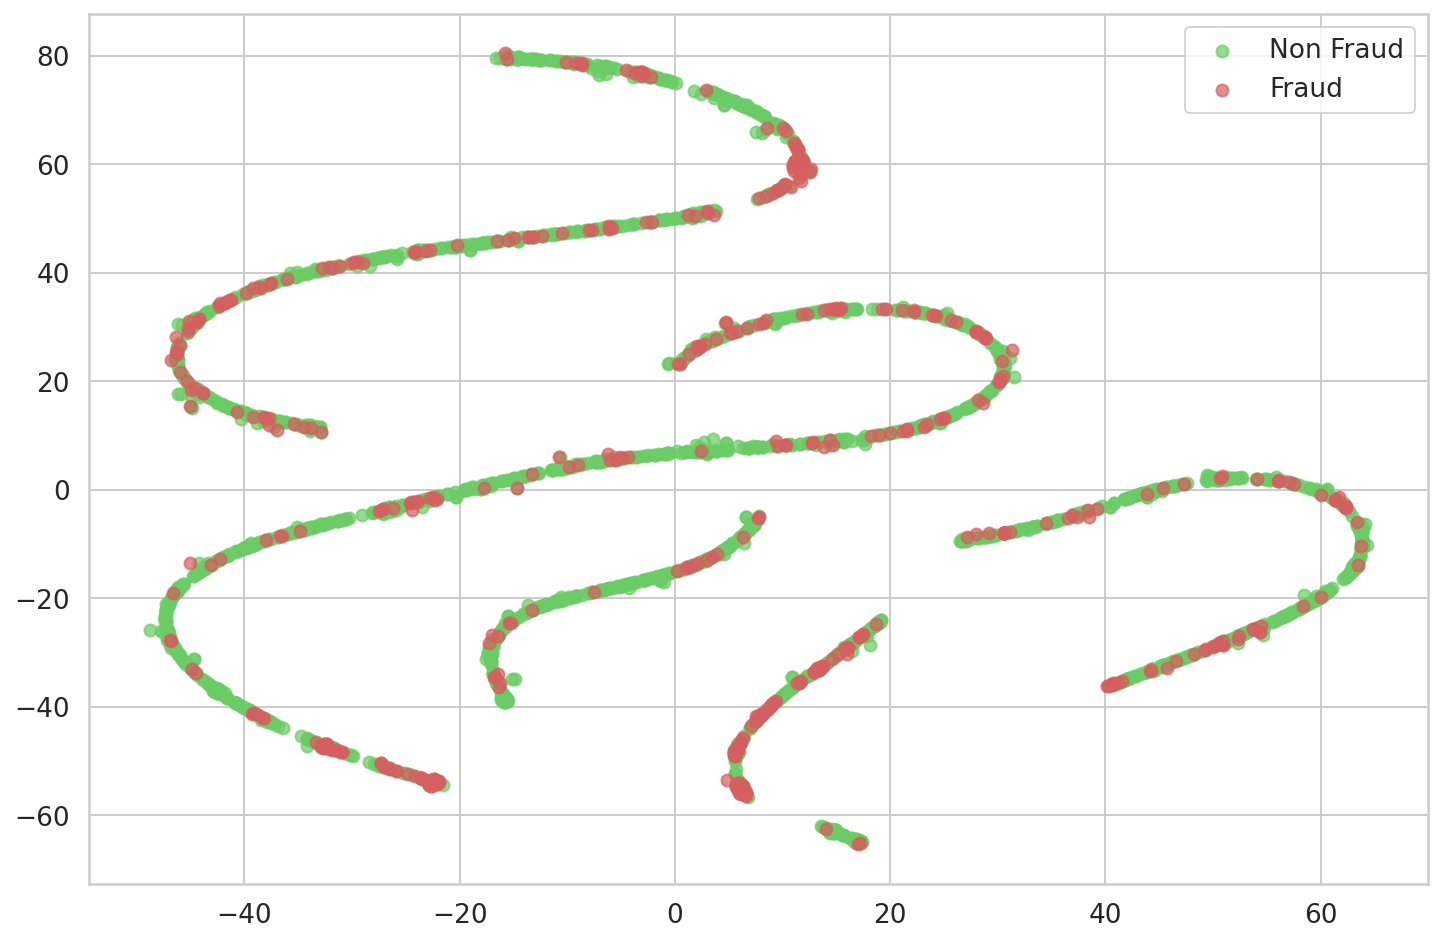

In [453]:
plt.figure()
plt.scatter(p[np.where(y == 0), 0], p[np.where(y == 0), 1], marker='o', color='g', linewidth='1', alpha=0.7, label='Non Fraud')
plt.scatter(p[np.where(y == 1), 0], p[np.where(y == 1), 1], marker='o', color='r', linewidth='1', alpha=0.7, label='Fraud')

plt.legend(loc='best');
plt.show();

Analyzing this it becomes really hard to determine the decision boundary for fraud vs non-fraud cases.

# Train-Test Split

In [454]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=TEST_SIZE, random_state=RANDOM_SEED)
# X_train.shape, X_test.shape

# Normalize data

In [455]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

In [456]:
X_non = X_sc[y==0]
X_fraud = X_sc[y==1]

# Autoencoder

In [457]:
BATCH_SIZE = 128
EPOCH = 20
SHUFFLE = True
TEST_SIZE = 0.2

In [458]:
inp = Input(shape = (X_sc.shape[1],))

#encoder
x = Dense(100, activation= 'relu')(inp)
x = Dense(50, activation='relu')(x)
#decoder
x = Dense(50, activation= 'tanh')(x)
x = Dense(100, activation='tanh')(x)

#output 
output = Dense(X_sc.shape[1], activation='relu')(x)

autoencoder = Model(inp, output)

LR = 0.001
EPOCHS = 300
adam = Adam(lr = LR, decay = (LR/EPOCHS)) 

In [459]:
autoencoder.compile(optimizer=adam, loss='mse')
autoencoder.summary()

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 30)]              0         
_________________________________________________________________
dense_207 (Dense)            (None, 100)               3100      
_________________________________________________________________
dense_208 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_209 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_210 (Dense)            (None, 100)               5100      
_________________________________________________________________
dense_211 (Dense)            (None, 30)                3030      
Total params: 18,830
Trainable params: 18,830
Non-trainable params: 0
_________________________________________________

In [460]:
history = autoencoder.fit(X_sc, X_sc, 
                batch_size = BATCH_SIZE, 
                epochs = EPOCH, 
                shuffle = SHUFFLE, 
                validation_split = TEST_SIZE);

Epoch 1/20
16/16 [==============================] - 0s 9ms/step - loss: 0.9492 - val_loss: 0.9329
Epoch 2/20
16/16 [==============================] - 0s 3ms/step - loss: 0.8720 - val_loss: 0.8753
Epoch 3/20
16/16 [==============================] - 0s 4ms/step - loss: 0.8164 - val_loss: 0.8177
Epoch 4/20
16/16 [==============================] - 0s 3ms/step - loss: 0.7606 - val_loss: 0.7827
Epoch 5/20
16/16 [==============================] - 0s 3ms/step - loss: 0.7299 - val_loss: 0.7588
Epoch 6/20
16/16 [==============================] - 0s 3ms/step - loss: 0.7066 - val_loss: 0.7420
Epoch 7/20
16/16 [==============================] - 0s 3ms/step - loss: 0.6902 - val_loss: 0.7304
Epoch 8/20
16/16 [==============================] - 0s 3ms/step - loss: 0.6778 - val_loss: 0.7187
Epoch 9/20
16/16 [==============================] - 0s 4ms/step - loss: 0.6666 - val_loss: 0.7077
Epoch 10/20
16/16 [==============================] - 0s 3ms/step - loss: 0.6572 - val_loss: 0.6990
Epoch 11/20
16/16 [

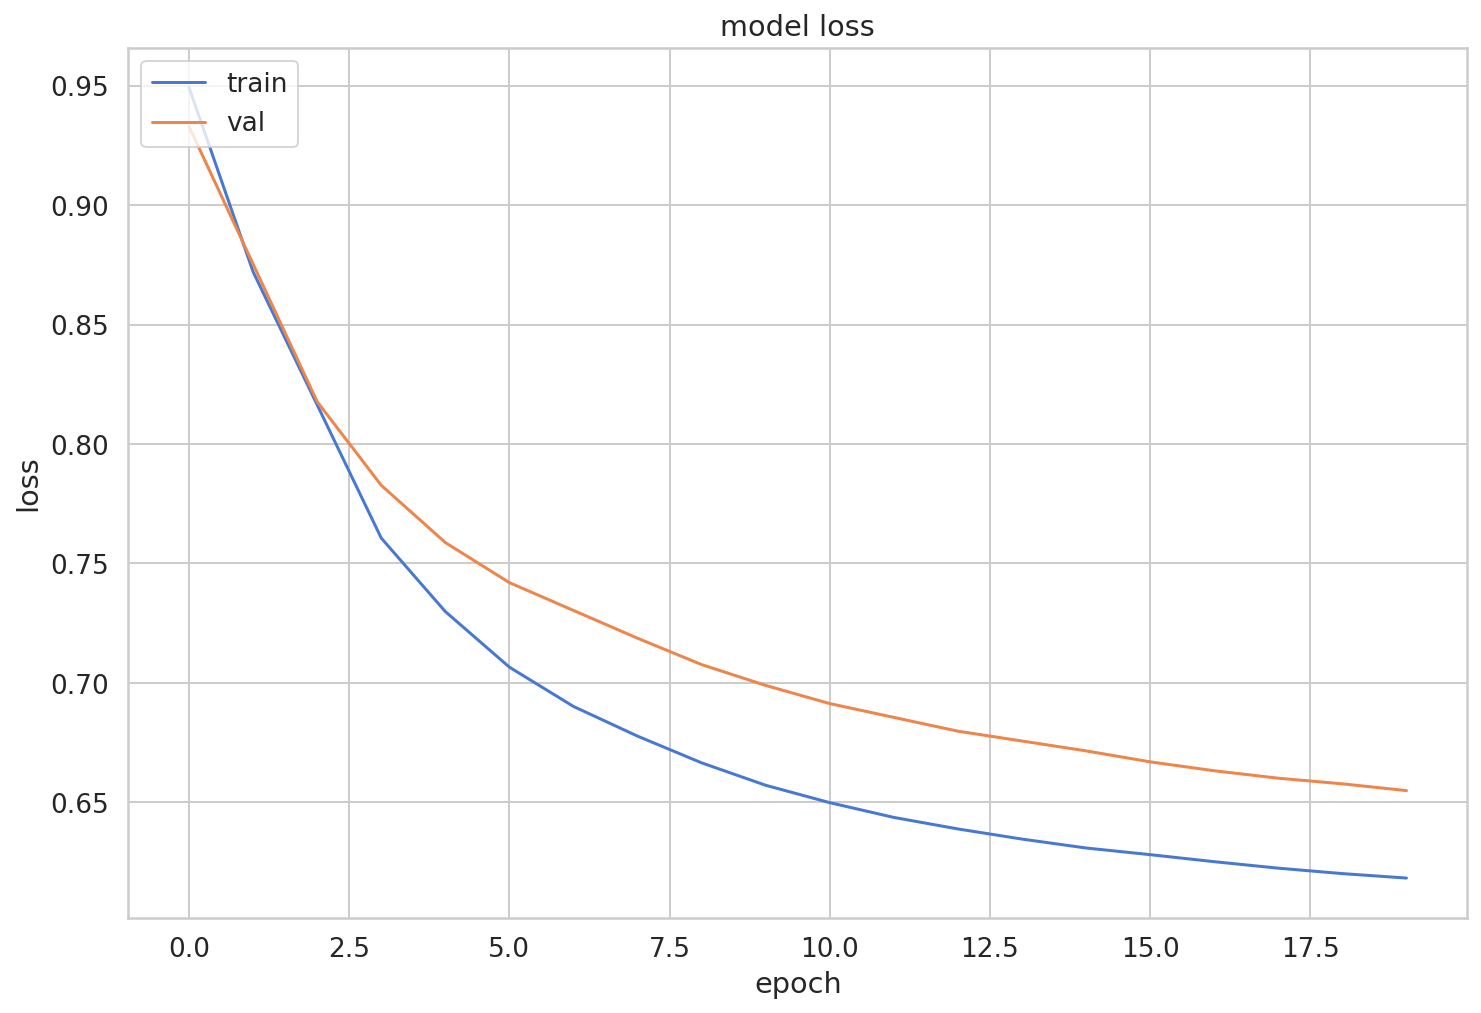

In [461]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [462]:
autoencoder.summary()

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 30)]              0         
_________________________________________________________________
dense_207 (Dense)            (None, 100)               3100      
_________________________________________________________________
dense_208 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_209 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_210 (Dense)            (None, 100)               5100      
_________________________________________________________________
dense_211 (Dense)            (None, 30)                3030      
Total params: 18,830
Trainable params: 18,830
Non-trainable params: 0
_________________________________________________

In [463]:
encoder = Sequential()
encoder.add(autoencoder.layers[0])
encoder.add(autoencoder.layers[1])
encoder.add(autoencoder.layers[2])

decoder = Sequential()
decoder.add(autoencoder.layers[3])
decoder.add(autoencoder.layers[4])
decoder.add(autoencoder.layers[5])

# Take the hidden represenation from encoder

In [464]:
non_hid_rep = encoder.predict(X_non)
fraud_hid_rep = encoder.predict(X_fraud)
converted_x = np.append(non_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(non_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
converted_y = np.append(y_n, y_f)

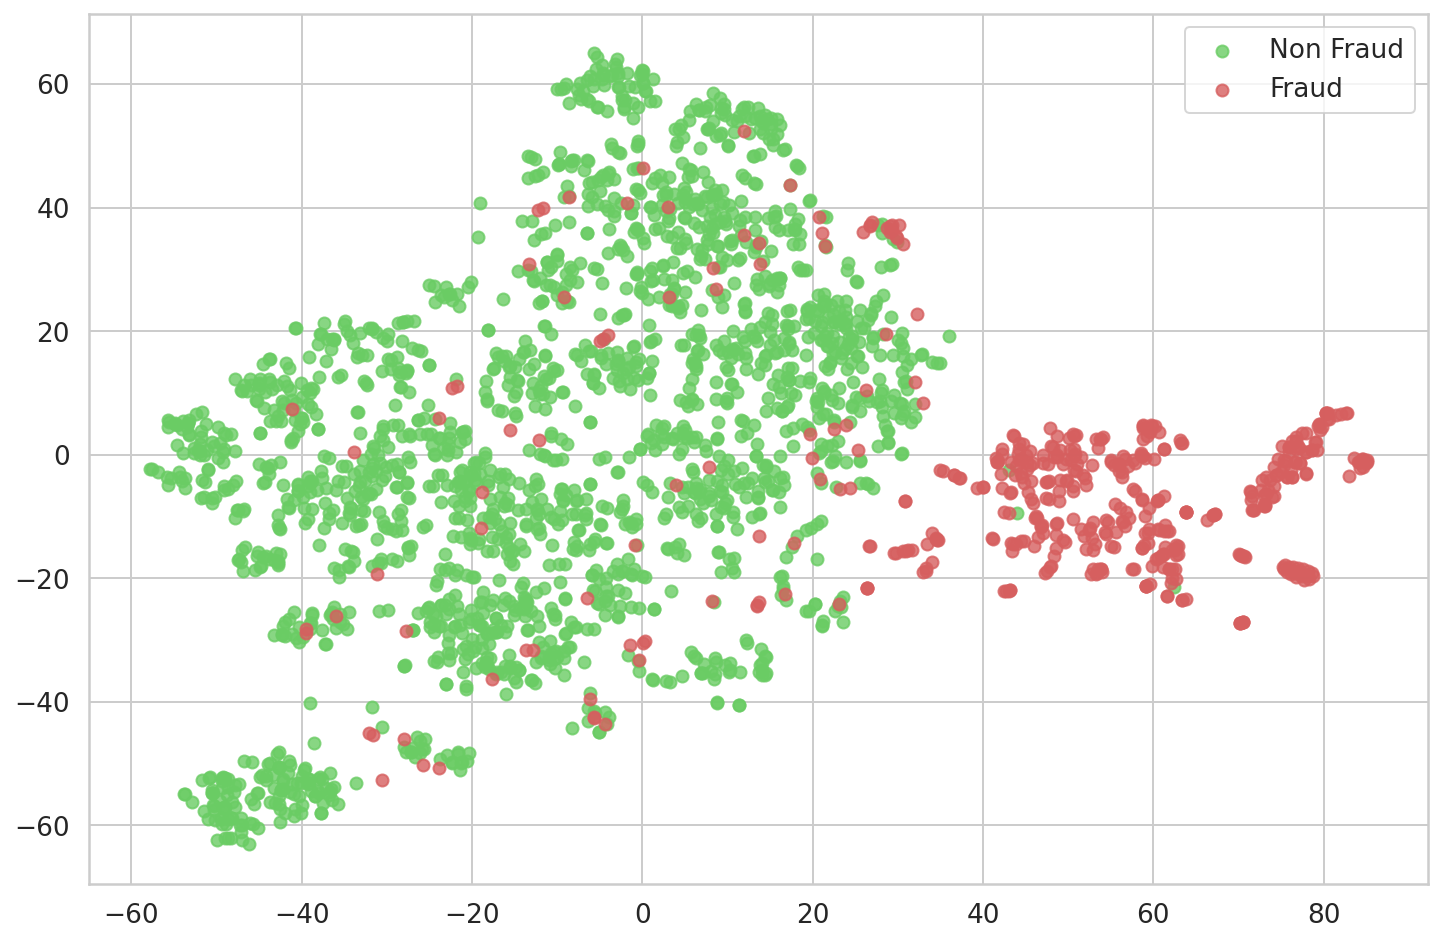

In [465]:

p = TSNE(n_components=2, random_state=RANDOM_SEED).fit_transform(converted_x)
plt.figure(figsize=(12, 8))
plt.scatter(p[np.where(converted_y == 0), 0], p[np.where(converted_y == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
plt.scatter(p[np.where(converted_y == 1), 0], p[np.where(converted_y == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

plt.legend(loc='best');
plt.show();

# Train Test Split

In [466]:
train_x, test_x, train_y, test_y = train_test_split(converted_x, converted_y, test_size=TEST_SIZE)

# Logistic Regression

In [467]:
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y_lr = clf.predict(test_x)

print ("")
print ("Classification Report: ")
print (classification_report(test_y, pred_y_lr))

print ("")
print ("AUC Score: ", roc_auc_score(test_y, pred_y_lr))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       408
         1.0       0.94      0.85      0.89        91

    accuracy                           0.96       499
   macro avg       0.95      0.92      0.93       499
weighted avg       0.96      0.96      0.96       499


AUC Score:  0.916949472096531


# SVM

In [468]:
clf = SVC(kernel='rbf').fit(train_x, train_y)
pred_y_svm = clf.predict(test_x)

print ("")
print ("Classification Report: ")
print (classification_report(test_y, pred_y_svm))

print ("")
print ("AUC Score: ", roc_auc_score(test_y, pred_y_svm))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       408
         1.0       0.97      0.82      0.89        91

    accuracy                           0.96       499
   macro avg       0.97      0.91      0.94       499
weighted avg       0.96      0.96      0.96       499


AUC Score:  0.9096369316957552


# KNN

In [469]:
clf = KNeighborsClassifier(n_neighbors=3).fit(train_x, train_y)
pred_y_knn = clf.predict(test_x)

print ("")
print ("Classification Report: ")
print (classification_report(test_y, pred_y_knn))

print ("")
print ("AUC Score: ", roc_auc_score(test_y, pred_y_knn))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       408
         1.0       0.96      0.82      0.89        91

    accuracy                           0.96       499
   macro avg       0.96      0.91      0.93       499
weighted avg       0.96      0.96      0.96       499


AUC Score:  0.9084114414996768


# MLP

In [470]:
#initialize variables 
num_epoch = 70
batch_size = 32
learning_rate = 0.01
regulizer = 0.01
verbose = 2
validation_split = 0.2
dropout_prob = 0.5

In [471]:
model = tf.keras.Sequential([
        tf.keras.layers.Dense(400, activation = 'relu', kernel_initializer = 'random_normal', input_dim = train_x.shape[1]),
        tf.keras.layers.Dropout(rate = 0.5),
        tf.keras.layers.Dense(400, activation = 'relu', kernel_initializer = 'random_normal', kernel_regularizer=regularizers.l1(0.01)),
        tf.keras.layers.Dense(200, activation = 'relu', kernel_initializer = 'random_normal'),
        tf.keras.layers.Dense(1, activation = 'sigmoid', kernel_initializer = 'random_normal')
        ])
model.summary()

opt = tf.optimizers.Adam()
model.compile(loss='binary_crossentropy', optimizer = opt, metrics = ['AUC'])
history = model.fit(train_x, 
                    train_y, 
                    epochs = num_epoch,
                    validation_split=validation_split,
                    batch_size = batch_size,
                    verbose=verbose)

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_212 (Dense)            (None, 400)               20400     
_________________________________________________________________
dropout_43 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_213 (Dense)            (None, 400)               160400    
_________________________________________________________________
dense_214 (Dense)            (None, 200)               80200     
_________________________________________________________________
dense_215 (Dense)            (None, 1)                 201       
Total params: 261,201
Trainable params: 261,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
50/50 - 0s - loss: 35.4113 - auc: 0.8464 - val_loss: 14.2947 - val_auc: 0.9865
Epoch 2/70
50/50 - 0s -

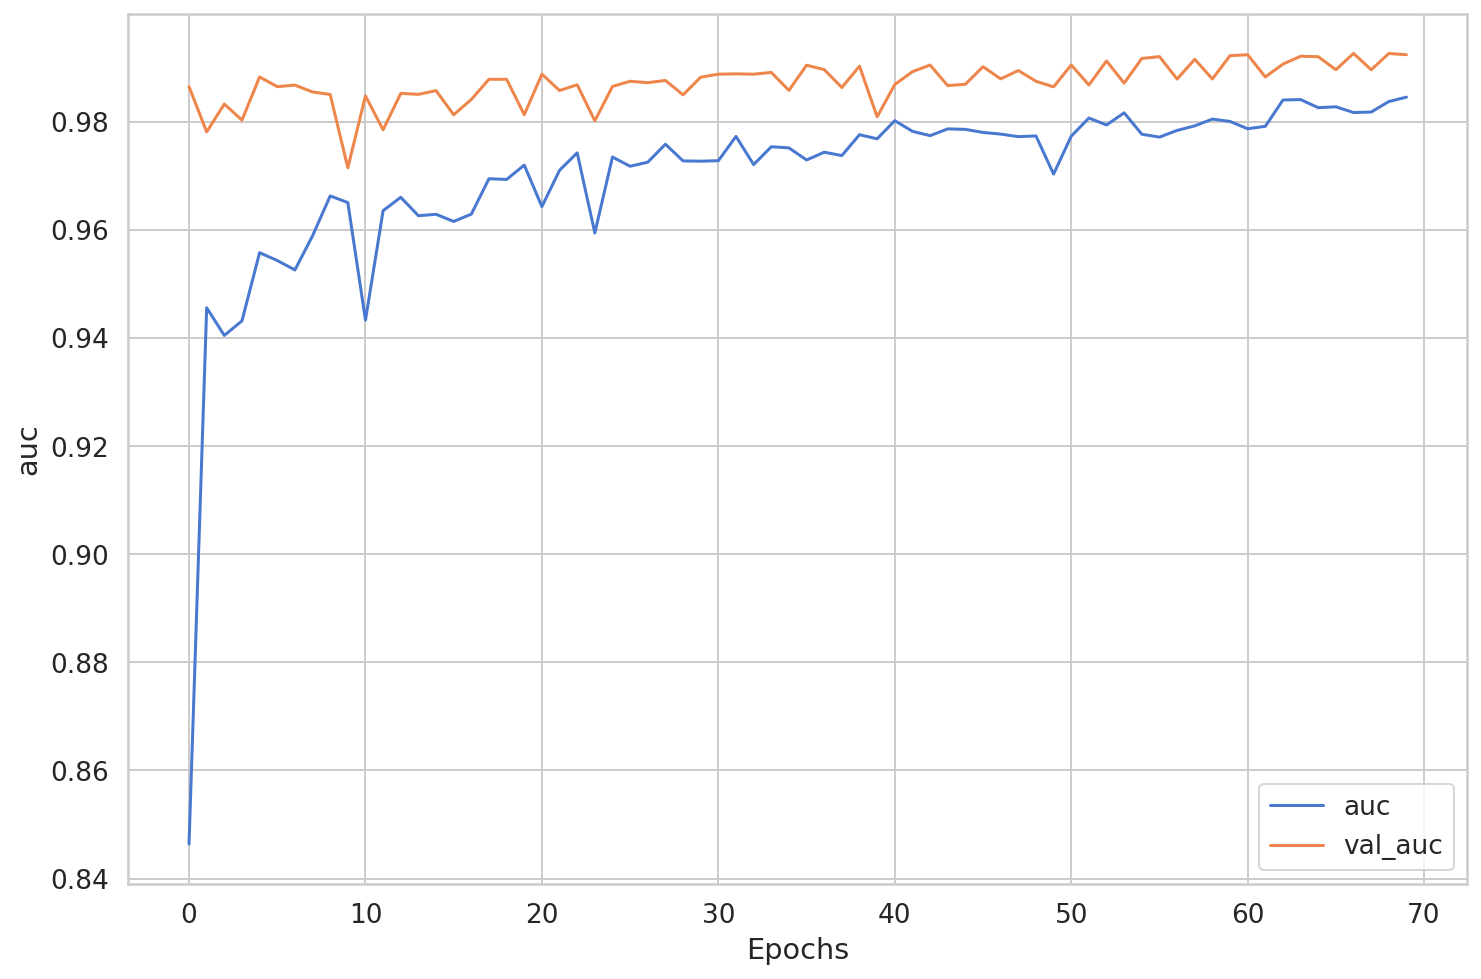

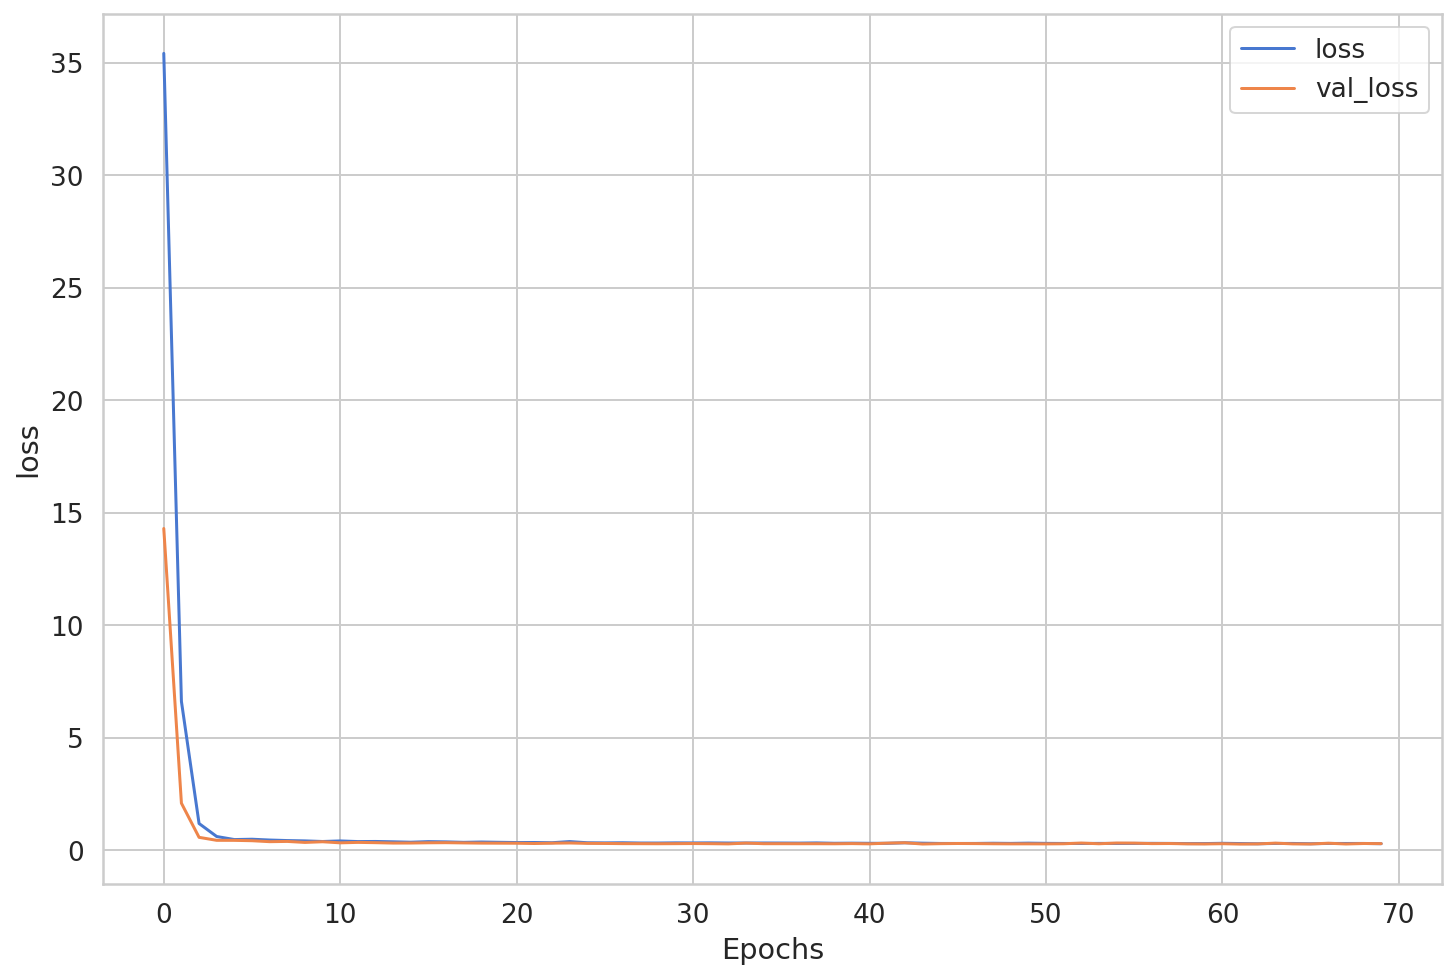

In [472]:
def plot_graphs(f, history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

#plot loss and accuracy 
f1 = plt.figure()
plot_graphs(f1,history, "auc")
f2 = plt.figure()
plot_graphs(f2,history, "loss")

In [473]:
loss, auc = model.evaluate(test_x,  test_y, verbose=2)

16/16 - 0s - loss: 0.3421 - auc: 0.9735


# Conclusion

Analyzing the models, we can see that the hidden representation from the encoder did a good job in separating fraud cases from the data. As, this problem has highly unbalanced distribution of fraud and non-fraud cases we report auc score as the preformance metric. Therefore, the best model achives auc = 0.97 using an artificial neural network. 